In [76]:
import os
import lightgbm as lgb
import json
import numpy as np
import pandas as pd
import warnings
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import metrics
from datetime import datetime
from math import sin, cos, sqrt, atan2, radians
from sklearn import ensemble, metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, classification_report, roc_auc_score, f1_score, log_loss

In [77]:
def load_df(csv_path='train.csv', nrows=None):
    json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in json_columns}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in json_columns:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [78]:
# Load both train and test data..
train = load_df(nrows = 100000)
test = load_df('test.csv')

In [79]:
print(train.shape, test.shape)

(100000, 55) (804684, 53)


<font size = 8> Task 1: Data Cleaning  </font> <br />
Following are some of the tasks done as part of data cleaning:<br />
(1) The JSON fields are parsed to extract the relevant fields from the entries and <br />
    create new columns in the dataset for each such entry.
(1) Find which fields are missing from test dataset but present in train dataset.
    Remove all such fields except the target totals.transactionRevenue which will not be absent in test dataset <br />
(2) In the data there are fields which are not filled(NULL). It is important to immoute thhese fields so that data is 
    more clean. <br/>
(3) Remove columns which have a single unique value. These columns are of no use as their value is constant throughout
    the data, thus can be dropped. <br/> 
</font>

In [80]:
# Find which fields are missing from test dataset but present in train dataset.
# Remove all such fields except the target totals.transactionRevenue which will not
# be absent in test dataset
set(train.columns).difference(set(test.columns))

{'totals.transactionRevenue', 'trafficSource.campaignCode'}

In [81]:
train = train.drop(['trafficSource.campaignCode'], axis = 1)

In [82]:
# Doing some analysis on the data to figure out what can be cleaned
cdf = pd.concat([train.count(), train.nunique(), train.isna().sum()], axis = 1)
cdf = cdf.reset_index()
cdf.columns = ["Column_Name", "Total_Records", "Unique_Values", "Null_Values"]
cdf.sort_values('Unique_Values')[0:20]

,Column_Name,Total_Records,Unique_Values,Null_Values
15,device.mobileDeviceBranding,100000,1,0
28,geoNetwork.latitude,100000,1,0
35,totals.bounces,48916,1,51084
37,totals.newVisits,77263,1,22737
25,geoNetwork.cityId,100000,1,0
40,totals.visits,100000,1,0
23,device.screenResolution,100000,1,0
22,device.screenColors,100000,1,0
21,device.operatingSystemVersion,100000,1,0
19,device.mobileInputSelector,100000,1,0


In [83]:
# Carry out the same thing for the test data as well to make sure the data is actually consistent
cdf = pd.concat([test.count(), test.nunique(), test.isna().sum()], axis = 1)
cdf = cdf.reset_index()
cdf.columns = ["Column_Name", "Total_Records", "Unique_Values", "Null_Values"]
cdf.sort_values('Unique_Values')[0:20]

,Column_Name,Total_Records,Unique_Values,Null_Values
14,device.language,804684,1,0
32,geoNetwork.networkLocation,804684,1,0
25,geoNetwork.cityId,804684,1,0
35,totals.bounces,420948,1,383736
23,device.screenResolution,804684,1,0
22,device.screenColors,804684,1,0
21,device.operatingSystemVersion,804684,1,0
37,totals.newVisits,604370,1,200314
19,device.mobileInputSelector,804684,1,0
18,device.mobileDeviceModel,804684,1,0


In [84]:
def impute_data_fields(train,test):
    # Here we. impute part of the. data, some of the imputations will be done by the label encoder later
    for df in [train, test]: 
        if(df is train):
            df['totals.transactionRevenue'] = df['totals.transactionRevenue'].fillna(0)
            
        df["totals.bounces"] = df["totals.bounces"].fillna(0)
        df["totals.pageviews"] = df["totals.pageviews"].fillna(0)
        df["totals.hits"] = df["totals.hits"].fillna(0)
        df["totals.newVisits"] = df["totals.newVisits"].fillna(0)

In [85]:
impute_data_fields(train,test)

In [86]:
def get_null_percent(data):
    rows = []
    for x in data.columns:
        percent = 100-(data[x].count()/data[x].shape[0] * 100)
        rows.append([x,percent])
    output = pd.DataFrame(rows,columns=('Column Name','Null Percent'))
    output = output.sort_values(['Null Percent'], ascending=False)
    return output

Text(0.5,0,'Percent')

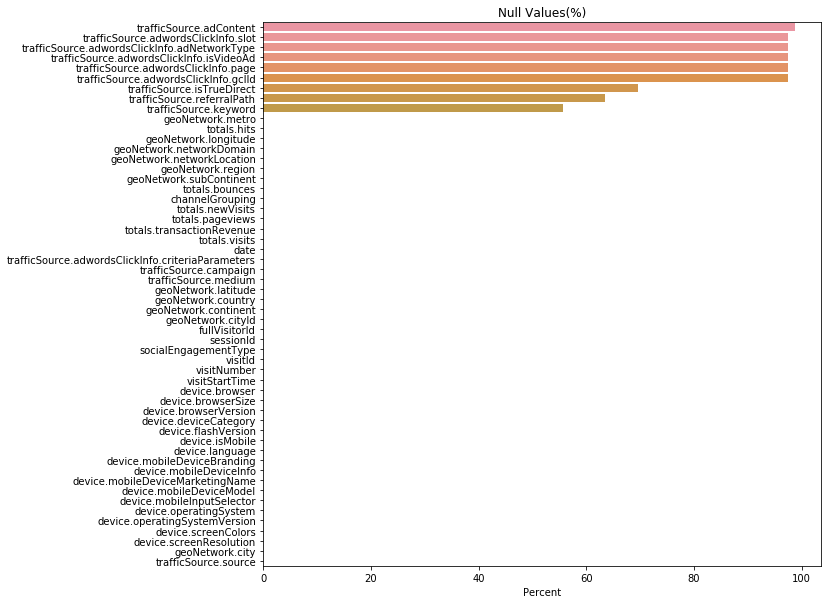

In [87]:
missing_df = get_null_percent(train)
missing_df.shape
plt.figure(figsize = [10,10])
sns.barplot(y = missing_df['Column Name'].values , x=missing_df['Null Percent'].values)
plt.title('Null Values(%)')
plt.xlabel("Percent")

In [88]:
# Drop all constant columns
def drop_constant_cols(df):
    cols_with_one_value = [c for c in df.columns if df[c].nunique(dropna=False) == 1]
    cols_to_drop = cols_with_one_value
    cols_to_drop.sort()
    df = df.drop(cols_to_drop, axis = 1)
    return df

In [89]:
train = drop_constant_cols(train)
test = drop_constant_cols(test)

In [90]:
print(train.shape, test.shape)

(100000, 35) (804684, 34)


In [91]:
# Figuring out the 80/20 rule from the data and see if it can be verified from the data as well
# Convert the output/target value to float 
train['totals.transactionRevenue'] = train['totals.transactionRevenue'].fillna(0).astype(float)

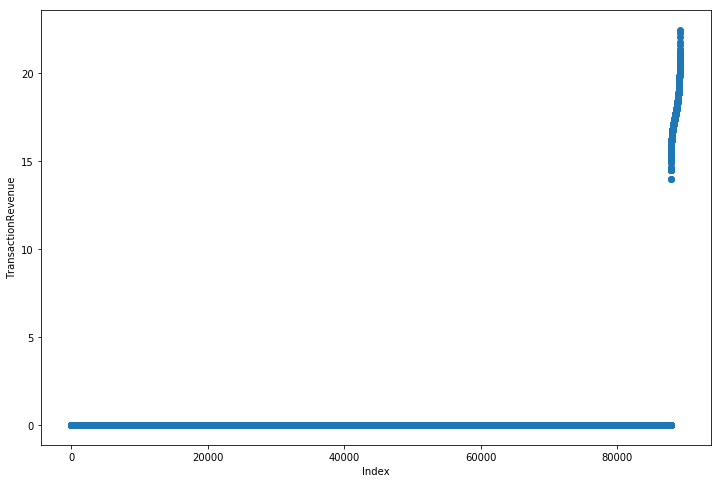

In [92]:
# Plot the relation of transaction revenue with user id to confirm the. 80/20 rule in
# businesses.  We see that indeed most of the revenue comes from a small fraction of the user
# since the plot is densely populated on one end of the axis.
temp_df = train[["fullVisitorId","totals.transactionRevenue"]].copy()
target = np.log1p(temp_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum())
target.describe()

plt.figure(figsize=(12,8))
plt.scatter(range(target.shape[0]), np.sort(target.values))
plt.xlabel('Index', fontsize=10)
plt.ylabel('TransactionRevenue', fontsize=10)
plt.show()

<font size = 8> Task 2: Some Interesting Correlations/Plots  </font>
<font > <br />
Some Plots which can help in building better ubderstanding with the data and validating our proof of concept <br />
(1) HeatMap -  We will plot a heatmap showing the positive/negative correlations in the data variables/features.  <br />
(2) Plot (1) -  We will plot some temporal relation in the data and see if they are consistent
with our understandin. It is observed that the transaction revenue is high for a date on which
number of visits were high. The plot shows symmetry in the data as well.<br />
(3) Plot (2) - We see that count plot shows decreasing nature i.e. we have a very high total count for less number of hits 
and page views per visitor transaction and the overall count decreases when the number of hits 
per visitor transaction increases.<br />
</font>

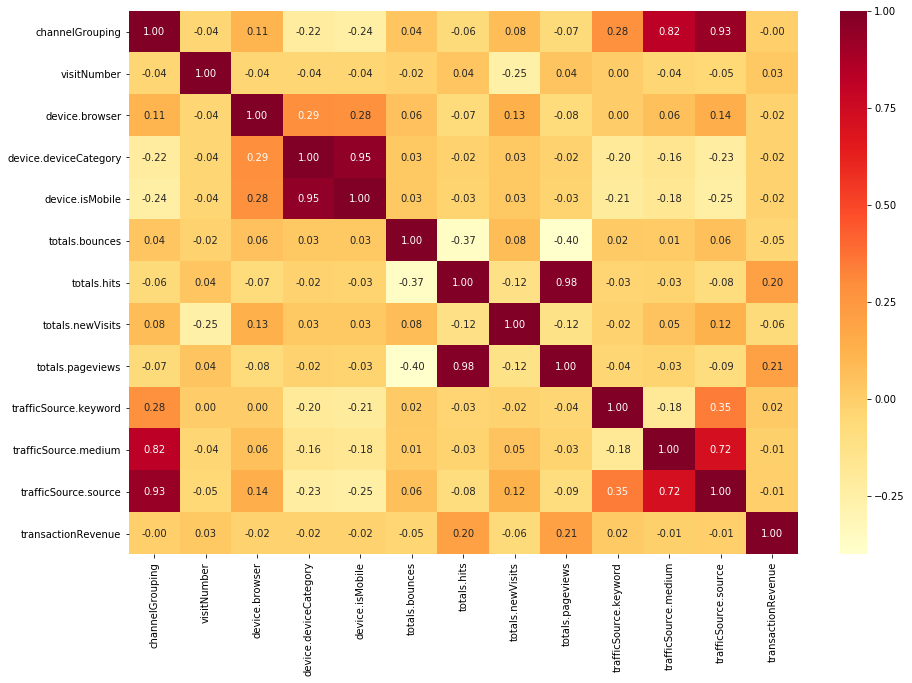

In [93]:
temp_df = train.copy()
#df['totals.transactionRevenue'] = df['totals.transactionRevenue'].apply(lambda x : 0.0 if x < 1 else np.log1p(x))
#Labeln encode the categorical features before sending to the model for prediction   
all_feat = temp_df.columns

totals_feat = ['totals.bounces','totals.hits','totals.newVisits', 'totals.pageviews']
for col in totals_feat:
    temp_df[col] = temp_df[col].astype(np.float)
    
temp_df['transactionRevenue'] = temp_df['totals.transactionRevenue'].astype(np.float)

unused_feat = ['date', 'fullVisitorId', 'sessionId', 
                'totals.transactionRevenue', 'visitId', 'visitStartTime']

temp_df = temp_df.drop(unused_feat, axis = 1)
#Removing irrelevant features from the set
traffic_feat_to_keep = ['trafficSource.keyword', 'trafficSource.medium', 'trafficSource.source']
geo_feat_to_keep = ['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', \
                    'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', ]

unused_traffic_feat = [c for c in train.columns if c.startswith('traffic') and c not in traffic_feat_to_keep]
unused_geo_feat = [c for c in train.columns if c.startswith('geoNetwork') and c not in traffic_feat_to_keep]

irrelevant_feat = unused_traffic_feat + unused_geo_feat + ['device.operatingSystem']

categorical_feat = [ col for col in temp_df.columns 
                        if (col not in unused_feat) & (col not in irrelevant_feat) & (temp_df[col].dtype == 'object')]

for column in categorical_feat:
    lbe = preprocessing.LabelEncoder()
    lbe.fit(list(temp_df[column].values.astype('str')))
    temp_df[column] = lbe.transform(list(temp_df[column].values.astype('str')))
corr = temp_df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr,annot=True, fmt="0.2f", cmap='YlOrRd')

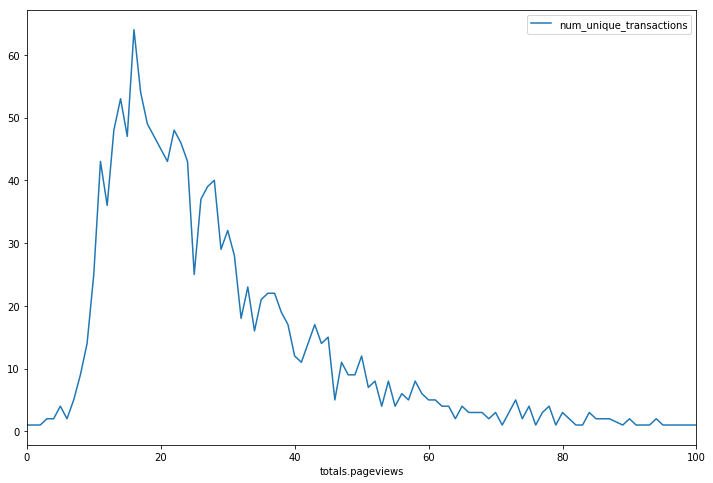

In [94]:
totals_feat = ['totals.bounces','totals.hits','totals.newVisits', 'totals.pageviews']
df = pd.DataFrame()
for col in totals_feat:
    df[col] = train[col].astype(np.float)
    
df['transactionRevenue'] = train['totals.transactionRevenue'].astype(np.float)
temp = df.groupby('totals.pageviews')['transactionRevenue'].unique()
df_new = pd.DataFrame(temp)
df_new['num_unique_transactions'] = [len(temp[c]) for c in temp.index]
del df_new['transactionRevenue']
df_new = df_new.reset_index()
df_new.plot('totals.pageviews', 'num_unique_transactions',xlim = (0,100), figsize=(12,8))

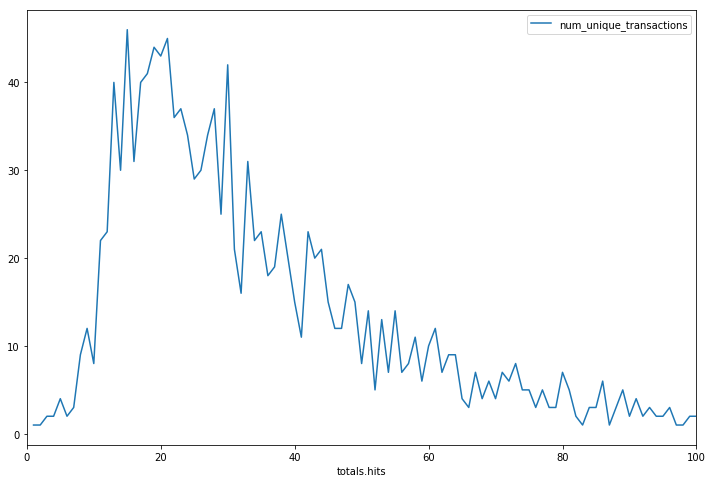

In [95]:
temp = df.groupby('totals.hits')['transactionRevenue'].unique()
df_new = pd.DataFrame(temp)
df_new['num_unique_transactions'] = [len(temp[c]) for c in temp.index]
del df_new['transactionRevenue']
df_new = df_new.reset_index()
df_new.plot('totals.hits', 'num_unique_transactions', xlim = (0,100), figsize=(12,8))

In [96]:
def plot_data(data, col, title='',size=(7,7),topx = 10, showplot = True):
    df = pd.DataFrame()
    # Normalize the count so that it can be analyzed easily.
    plotdata0 = data.groupby(col)['totals.transactionRevenue'].size()/len(data)
    df['Normalized_Count'] = plotdata0
    plotdata1 = data.groupby(col)['totals.transactionRevenue'].count()
    df['Non_Zero_Revenue_Count'] = plotdata1
    plotdata2 = data.groupby(col)['totals.transactionRevenue'].mean()
    df['Mean_Revenue'] = plotdata2
    df = df.sort_values('Normalized_Count', ascending=False)[0:topx]
    if(showplot):
        f, axes = plt.subplots(3, 1, figsize=size, sharex=True, squeeze=False)
        axes[0][0].set_title(title + " : Total Count Normalized")
        axes[0][0].set_ylabel('Normalized Count')
        axes[1][0].set_title(title + " : Non Zero Revenue Count")
        axes[1][0].set_ylabel('Non Zero Revenue Count')
        axes[2][0].set_title(title + " : Mean Revenue")
        axes[2][0].set_ylabel('Mean Revenue')
        sns.barplot(x = df.index, y=df.Normalized_Count, ax = axes[0][0])
        sns.barplot(x = df.index, y=df.Non_Zero_Revenue_Count, ax=axes[1][0])
        sns.barplot(x = df.index, y=df.Mean_Revenue, ax=axes[2][0])
        plt.show()
    else:
        return df

In [97]:
# Now we will see some temporal relation in the data and see if they are consistent
# with our understandin. It is observed that the transaction revenue is high for a date on which
# number of visits were high. The plot shows symmetry in the data as well.

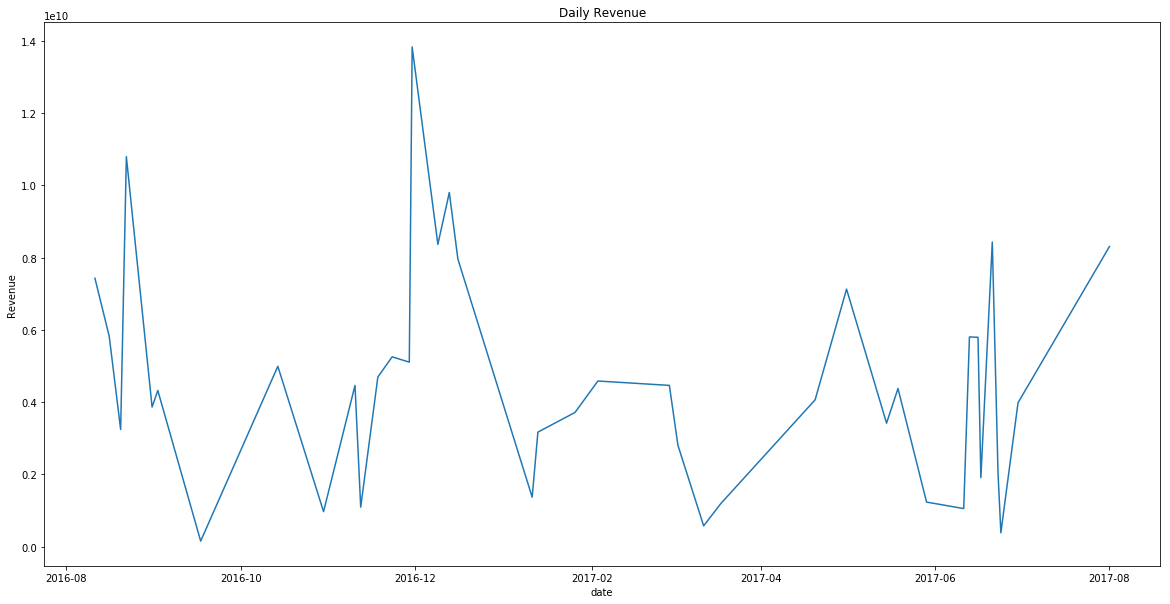

In [98]:
#Lets do some more time/date based analysis
train["formated_date"] = pd.to_datetime(train["date"],format="%Y%m%d")
revenue_date_df = train[["totals.transactionRevenue" , "formated_date"]].dropna()
revenue_date_df["totals.transactionRevenue"] = revenue_date_df["totals.transactionRevenue"].astype(float)
daily_revenue_df = revenue_date_df.groupby(by=["formated_date"],axis = 0 ).sum()
fig, axes = plt.subplots(figsize=(20,10))
axes.set_title("Daily Revenue")
axes.set_ylabel("Revenue")
axes.set_xlabel("date")
axes.plot(daily_revenue_df["totals.transactionRevenue"])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


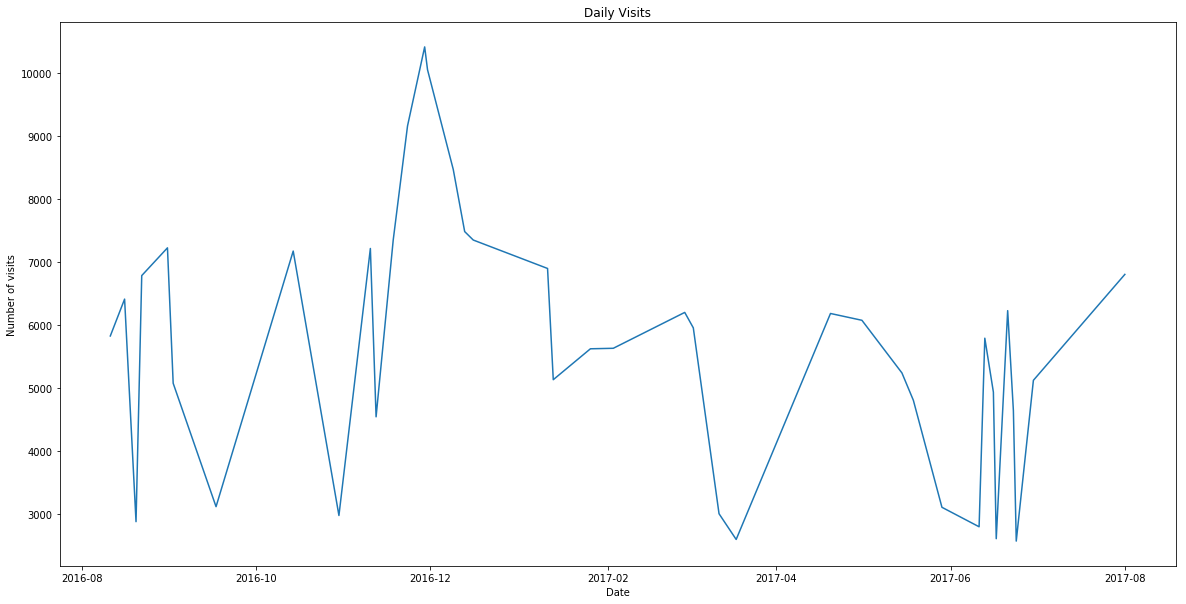

In [99]:
visit_dt_df = train[["formated_date","visitNumber"]]
visit_dt_df["visitNumber"] = visit_dt_df.visitNumber.astype(np.int64)

daily_visit_df = visit_dt_df.groupby(by=["formated_date"], axis = 0).sum()

fig, axes = plt.subplots(1,1,figsize=(20,10))
axes.set_ylabel("Number of visits")
axes.set_xlabel("Date")
axes.set_title("Daily Visits")
axes.plot(daily_visit_df["visitNumber"])

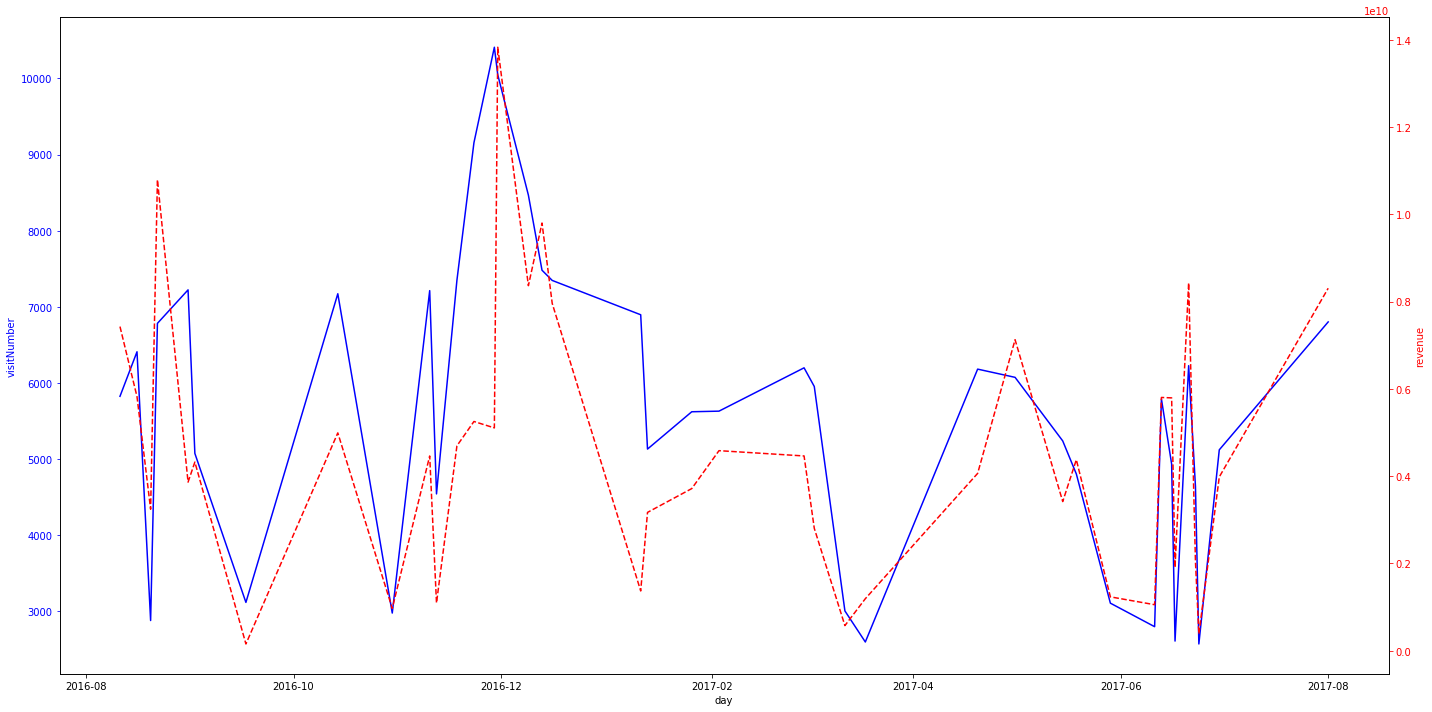

In [100]:
total_revenue_daily_df = revenue_date_df.groupby(by=["formated_date"],axis=0).sum()
total_visitNumber_daily_df = train[["formated_date","visitNumber"]].groupby(by=["formated_date"],axis=0).sum()
datetime_revenue_visits_df = pd.concat([total_revenue_daily_df,total_visitNumber_daily_df],axis=1)

fig, ax1 = plt.subplots(figsize=(20,10))
t = datetime_revenue_visits_df.index
s1 = datetime_revenue_visits_df["visitNumber"]
ax1.plot(t, s1, 'b-')
ax1.set_xlabel('day')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('visitNumber', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
s2 = datetime_revenue_visits_df["totals.transactionRevenue"]
ax2.plot(t, s2, 'r--')
ax2.set_ylabel('revenue', color='r')
ax2.tick_params('y', colors='r')
fig.tight_layout()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1b5d01c588>,
      dtype=object)

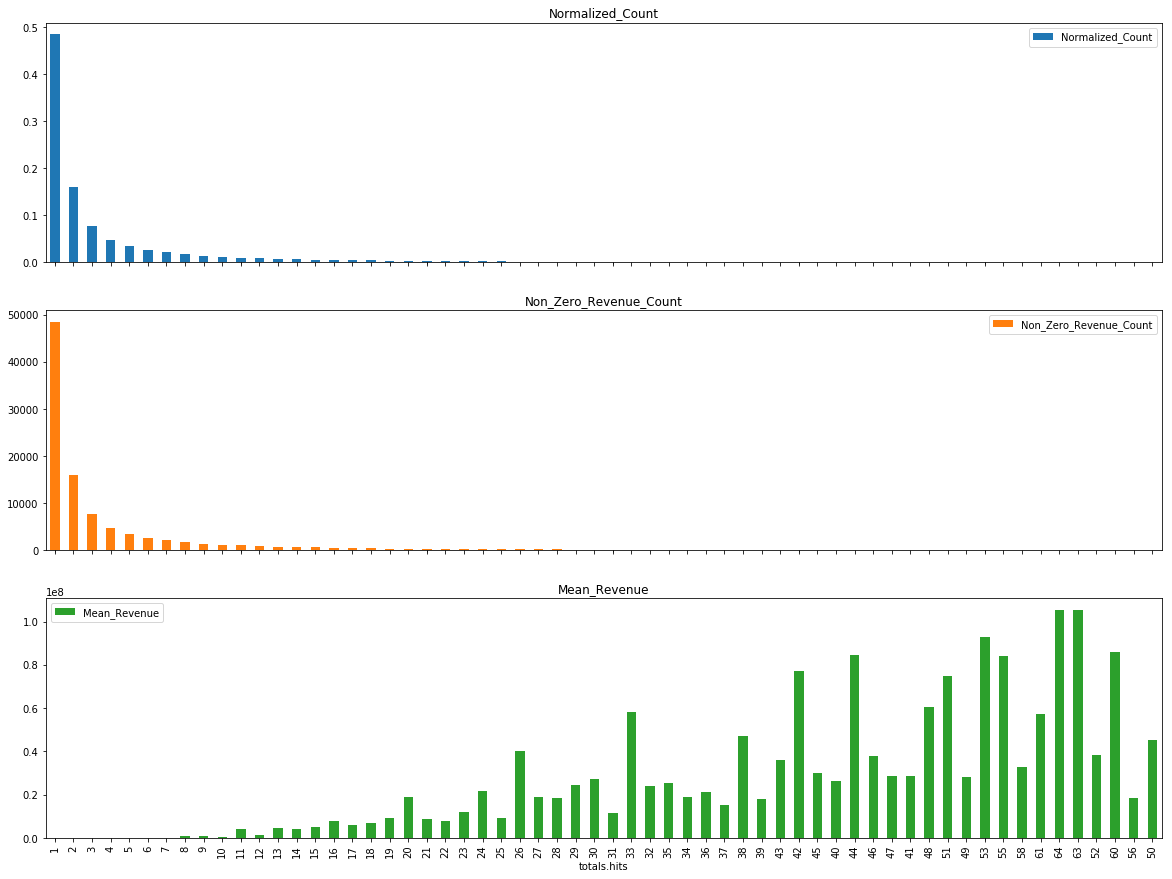

In [101]:
# Plot (2):
#We see that count plot shows decreasing nature i.e. we have a very high total count for less number of hits 
#and page views per visitor transaction and the overall count decreases when the number of hits 
#per visitor transaction increases.
df = plot_data(data=train, col='totals.hits', title='Total - PageViews', size=[15,15], topx = 60 , showplot = False)
df.plot.bar(subplots=True, figsize = (20,15))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1b5d90a0b8>,
      dtype=object)

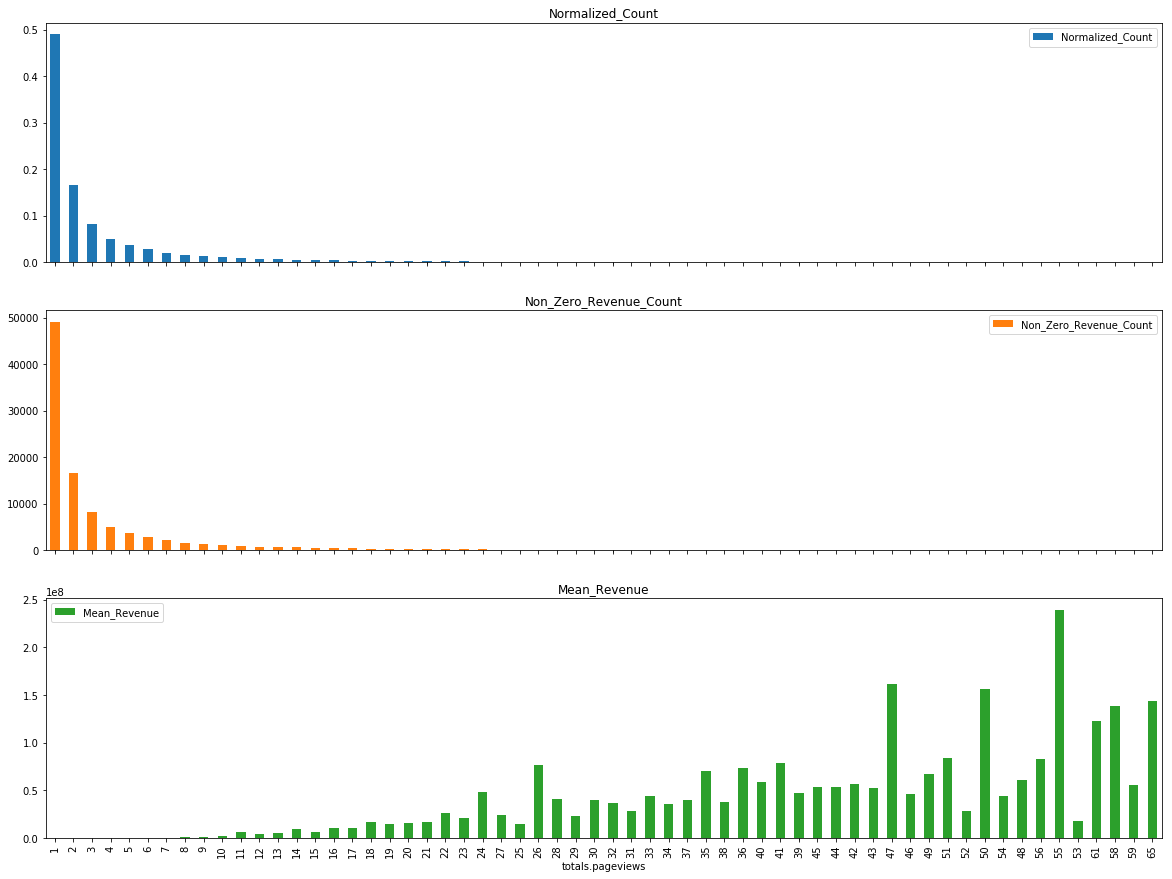

In [102]:
df = plot_data(data=train, col='totals.pageviews', title='Total - PageViews', size=[15,15], topx = 60 , showplot = False)
df.plot.bar(subplots=True, figsize = (20,15))

<font size = 8> Task 3: Clustering data on Geography </font> <br />
<font>    
Plot 1 is a set of three plots each depicting the number of visits done by users of each city to the site these include visits that resulted into transactions as well those which didn't. <br \>
I have plotted the normalized value as the range in order to prevent scaling issues. The second plot in the subplot tells the count of non zero transactions made by users of a city. The third subplot shows the mean revenue generated by each city. Similar plots have been plotted for continent, city, subcontinent etc.
</font>

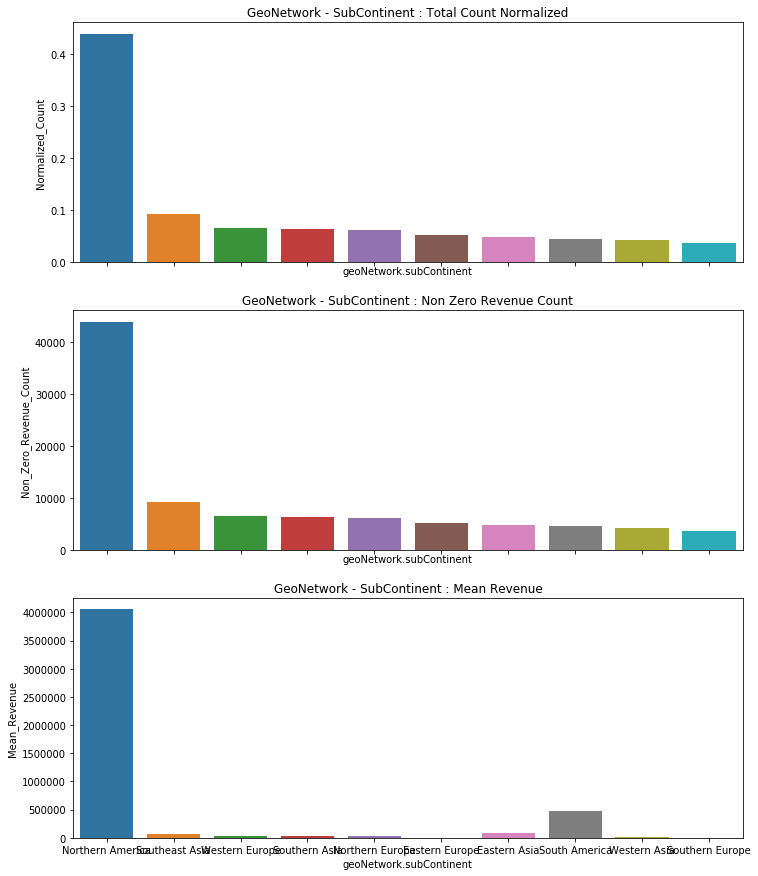

In [103]:
plot_data(data=train, col='geoNetwork.subContinent', title='GeoNetwork - SubContinent', size=[12,15])

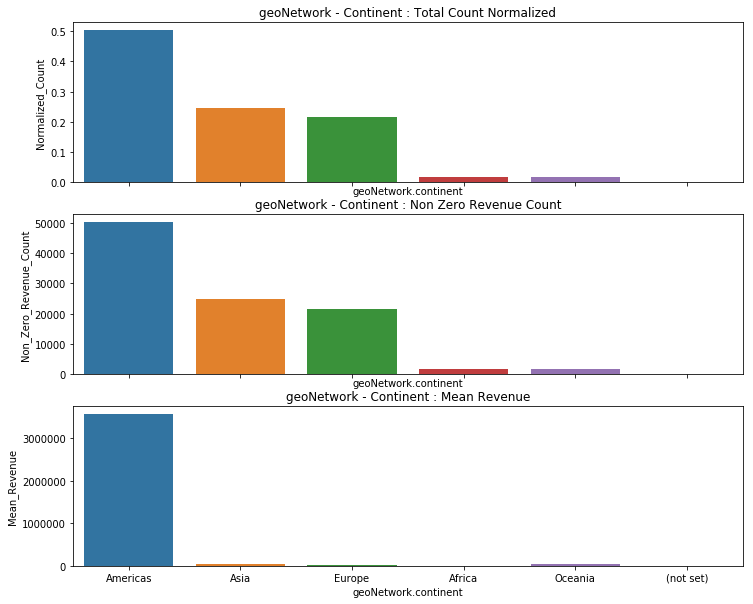

In [104]:
plot_data(data=train, col='geoNetwork.continent', title='geoNetwork - Continent', size=[12,10])

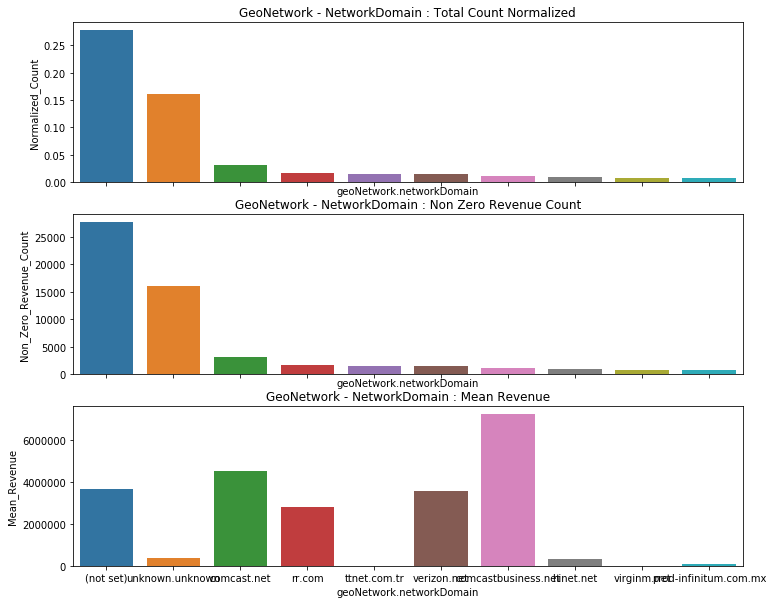

In [105]:
plot_data(data=train, col='geoNetwork.networkDomain', title='GeoNetwork - NetworkDomain', size=[12,10])

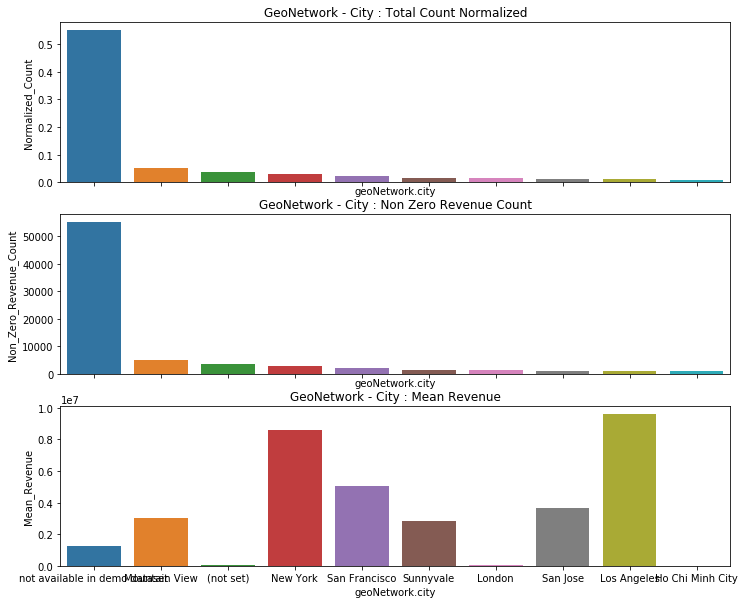

In [106]:
plot_data(data=train, col='geoNetwork.city', title='GeoNetwork - City', size=[12,10])

<font size = 8> Task 4: Buying Score/Probability </font>

In [107]:
# Lets group the data based on user id in order to give it a score. For this we will find the the number of visits he
# made to the store and total number of transactions he did. based on these two data we will be able to assign a 
# score for each user id
df_new = train[['fullVisitorId','visitNumber','totals.transactionRevenue']].copy()
df_new['totals.transactionRevenue'] = df_new['totals.transactionRevenue'].astype(bool)
agg_dict = {}
agg_dict['visitNumber'] = "max"
agg_dict['totals.transactionRevenue'] = "sum"
df_new = df_new.groupby('fullVisitorId').agg(agg_dict).reset_index()
df_new[df_new['totals.transactionRevenue'] > 1].head()

,fullVisitorId,visitNumber,totals.transactionRevenue
4038,0463325773564352787,4,2.0
5272,0608915197735218105,6,2.0
5577,0642830728760694475,9,2.0
9816,1111470101899387454,4,2.0
10162,1152867987950849273,2,2.0


In [108]:
df_new['buy_probability'] = df_new['totals.transactionRevenue']/df_new['visitNumber']
top_clients = df_new.sort_values('buy_probability', ascending= False)['fullVisitorId'][0:10]
print("Client Id's of top 10 users who are most likely to buy from GStore are : \n" , top_clients.values)

Client Id's of top 10 users who are most likely to buy from GStore are : 
 ['653069947099114599' '2518447979646501002' '9710480501909231921'
 '8186007457246709564' '3614707430894059857' '6275380876231092642'
 '144847938814859371' '5970035247923497864' '1881458907401964229'
 '3112141012835314636']


In [34]:
#session_feat = ['sessionId','visitId','visitStartTime']
totals_feat = ['totals.bounces','totals.hits','totals.newVisits', 'totals.pageviews']
target_col = ['totals.transactionRevenue']
numerical_feat = totals_feat + ['visitNumber']

for column_iter in numerical_feat:
    train[column_iter] = train[column_iter].astype(np.float)
    test[column_iter] = test[column_iter].astype(np.float)

In [35]:
# This feature breaks down the date into multiple fields like dya, year , nonth and other related stuff.
def add_date_feature(df):
    df['formated_date'] = pd.to_datetime(df['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))
    df['month'] = df['formated_date'].dt.month
    df['day'] = df['formated_date'].dt.day
    df['year'] = df['formated_date'].dt.year
    df['weekday'] = df['formated_date'].dt.weekday
    df['weekofyear'] = df['formated_date'].dt.weekofyear
    #Do the same processing for test data as well to keep it consistent with the train data
    df = df.drop(['formated_date'], axis=1)
    return df

# This feature groups the data on fullVisitorId to figure out how many transactions each user made
def add_buycount_feature(df):
    buycount = df.groupby('fullVisitorId')['visitId'].count().reset_index()
    buycount.columns = ['fullVisitorId','buy_count']
    df = pd.merge(train, buycount, on=['fullVisitorId'], how='left')
    df['buy_count'].fillna(0, inplace=True)
    return df
   
# This feature will 
def add_hit_rate_feature(df):
    df['hit_rate'] = df['totals.hits'] / df['totals.pageviews']
    return df

In [36]:
def add_features(df):
    # Add date extracted date columns
    df = add_date_feature(df)
    # Add buycount feature ==> Cumulative visits on the store for each user/sessionId
    #df = add_buycount_feature(df)
    # Add hit_rate_feature
    df = add_hit_rate_feature(df)
    # Some more features based on aggregation of columns
    df['month_unique_user_count'] = df.groupby('month')['fullVisitorId'].transform('nunique')
    df['day_unique_user_count'] = df.groupby('day')['fullVisitorId'].transform('nunique')
    df['weekday_unique_user_count'] = df.groupby('weekday')['fullVisitorId'].transform('nunique')
    df['weekofyear_unique_user_count'] = df.groupby('weekofyear')['fullVisitorId'].transform('nunique')
    df['mean_hits_per_day'] = df.groupby(['day'])['totals.hits'].transform('mean')
    df['sum_hits_per_day'] = df.groupby(['day'])['totals.hits'].transform('sum')
    df['user_pageviews_sum'] = df.groupby('fullVisitorId')['totals.pageviews'].transform('sum')
    df['user_hits_sum'] = df.groupby('fullVisitorId')['totals.hits'].transform('sum')
    df['user_pageviews_count'] = df.groupby('fullVisitorId')['totals.pageviews'].transform('count')
    df['user_hits_count'] = df.groupby('fullVisitorId')['totals.hits'].transform('count')
    

    return df

In [37]:
# Add some extra features to the data to improve the predictions
train = add_features(train)
test = add_features(test)

<font size = 8> Task 5: Adding Extrernal Dataset </font> <br />
<font>I picked up an external dataset from Kaggle itself from the following link <br/>
https://www.kaggle.com/satian/exported-google-analytics-data. There are couple of important fields in this <br/>
including avg session time, goal conversion rate etc.
</font>

In [38]:
#Add some external dataset to improve the model performance.
train_ext = pd.read_csv('Train_external_data.csv',skiprows=6, dtype={"Client Id":'str'})
test_ext = pd.read_csv('Test_external_data.csv',skiprows=6, dtype={"Client Id":'str'})

In [39]:
train_ext["visitId"] = train_ext["Client Id"].apply(lambda x: x.split('.', 1)[1]).astype(str)
test_ext["visitId"] = test_ext["Client Id"].apply(lambda x: x.split('.', 1)[1]).astype(str)

In [40]:
# Since Visit id is common among the ths given data set and external dataset,we will merge 
# the external set on visitID but before that we need to convert the visitId to numeric datatype since it's and
# object 
for df in [train, test, train_ext, test_ext]:
    df["visitId"] = df["visitId"].astype(int)
    
train = train.merge(train_ext, how="left", on="visitId")
test = test.merge(test_ext, how="left", on="visitId")

In [41]:
# Drop Client Id
for df in [train, test]:
    df.drop("Client Id",axis = 1, inplace=True)

In [42]:
# Remove $ from revenue field and fill empty fields with 0
for df in [train, test]:
    df_new = pd.DataFrame()
    df_new['Revenue'] = df["Revenue"].fillna('$')
    df_new["Revenue"] = df_new["Revenue"].apply(lambda x: x.replace('$', '').replace(',', ''))
    df_new['Revenue'] = pd.to_numeric(df_new['Revenue'],errors="coerce")
    df_new["Revenue"] = df_new["Revenue"].fillna(0.0)
    df['Revenue'] = df_new["Revenue"]
  #  df['is_high_hits'] = np.logical_or(df["totals.hits"]>4,df["totals.pageviews"]>4).astype(np.int32)
   # df['views/hits']= df["totals.pageviews"]/df["totals.hits"].dropna(0)

In [43]:
def impute_ext_data_fields(df):
    df["Sessions"] = df["Sessions"].fillna(0)
    df['Bounce Rate'] = df['Bounce Rate'].fillna(0)
    df["Avg. Session Duration"] = df["Avg. Session Duration"].fillna(0)
    df["Transactions"] = df["Transactions"].fillna(0)
    df["Goal Conversion Rate"] = df["Goal Conversion Rate"].fillna(0)
    return df

In [44]:
train = impute_ext_data_fields(train)
test = impute_ext_data_fields(test)

In [45]:
target = train['totals.transactionRevenue']

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100001 entries, 0 to 100000
Data columns (total 57 columns):
channelGrouping                                 100001 non-null object
date                                            100001 non-null int64
fullVisitorId                                   100001 non-null object
sessionId                                       100001 non-null object
visitId                                         100001 non-null int64
visitNumber                                     100001 non-null float64
visitStartTime                                  100001 non-null int64
device.browser                                  100001 non-null object
device.deviceCategory                           100001 non-null object
device.isMobile                                 100001 non-null bool
device.operatingSystem                          100001 non-null object
geoNetwork.city                                 100001 non-null object
geoNetwork.continent                     

In [47]:
all_feat = train.columns

unused_feat = ['date', 'fullVisitorId', 'sessionId', 
                'totals.transactionRevenue', 'visitId', 'visitStartTime']

#Removing irrelevant features from the set
traffic_feat_to_keep = ['trafficSource.keyword', 'trafficSource.medium', 'trafficSource.source']

unused_traffic_feat = [c for c in train.columns if c.startswith('traffic') and c not in traffic_feat_to_keep]
unused_geo_feat = []

irrelevant_feat = unused_traffic_feat + unused_geo_feat + ['device.operatingSystem']

categorical_feat = [ col for col in train.columns 
                        if (col not in unused_feat) & (col not in irrelevant_feat) & (train[col].dtype == 'object')]

print(categorical_feat)
# Take the log of the prediction outout before passing it to the model
target = np.log1p(target)

df_train = train.drop(unused_feat, axis = 1)
# Unused features for test data will not have totals.transactions
unused_feat_test = unused_feat.copy()
unused_feat_test.remove('totals.transactionRevenue')
df_test = test.drop(unused_feat_test, axis = 1)

df_train = df_train.drop(irrelevant_feat, axis = 1)
df_test = df_test.drop(irrelevant_feat, axis = 1)

df_train["Revenue"] = np.log1p(df_train["Revenue"])
df_test["Revenue"] = np.log1p(df_test["Revenue"])

ext_categorical_features =  ['Bounce Rate', 'Goal Conversion Rate', 'Revenue']

categorical_feat += ext_categorical_features
#Labeln encode the categorical features before sending to the model for prediction to convert them to int/float
# as the model might complain if the input is fed as a string
for column in categorical_feat:
    lbe = preprocessing.LabelEncoder()
    lbe.fit(list(df_train[column].values.astype('str')) + list(df_test[column].values.astype('str')))
    df_train[column] = lbe.transform(list(df_train[column].values.astype('str')))
    df_test[column] = lbe.transform(list(df_test[column].values.astype('str')))

['channelGrouping', 'device.browser', 'device.deviceCategory', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.source', 'Avg. Session Duration', 'Bounce Rate', 'Goal Conversion Rate']


<font size = 8> Task 6: Predictive Modeling </font> <br />
<font> I have used a KFold LGBM model for prediction. The model works fairly good and provide quite nice RMSE value<br/>
</font>

Fold: 0
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[163]	training's rmse: 1.54504	valid_1's rmse: 1.44014
Fold: 1
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.33918	valid_1's rmse: 1.75255
Early stopping, best iteration is:
[576]	training's rmse: 1.32891	valid_1's rmse: 1.75058
Fold: 2
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.39404	valid_1's rmse: 1.17363
Early stopping, best iteration is:
[624]	training's rmse: 1.37784	valid_1's rmse: 1.17126
Fold: 3
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.34912	valid_1's rmse: 1.79977
[1000]	training's rmse: 1.2841	valid_1's rmse: 1.78815
[1500]	training's rmse: 1.22485	valid_1's rmse: 1.7795
Early stopping, best iteration is:
[1818]	training's rmse: 1.18601	valid_1's rmse: 1.77765
Fold: 4
Training until validation scores don't improve for 100 rounds.
[500]	tra

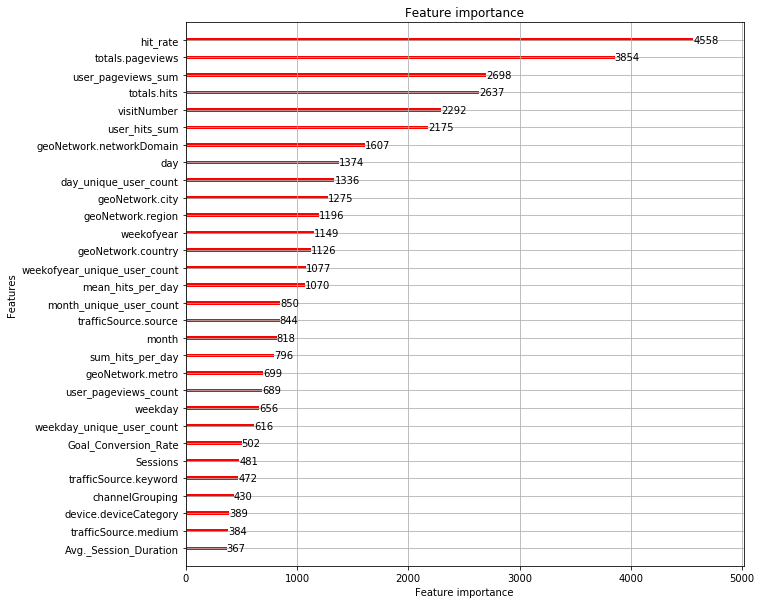

In [48]:
params = {
            "objective" : "regression", 
            "metric" : "rmse", 
            "max_depth": 8, 
            "min_child_samples": 20, 
            "reg_alpha": 0.2, 
            "reg_lambda": 0.2,
            "num_leaves" : 257,
            "learning_rate" : 0.01, 
            "subsample" : 0.9, 
            "colsample_bytree" : 0.9,
            "subsample_freq ": 5
        }
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=False, random_state=42)
# Cleaning and defining parameters for LGBM
model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
prediction = np.zeros(df_test.shape[0])

for fold_n, (train_index, test_index) in enumerate(folds.split(df_train)):
    print('Fold:', fold_n)
    #print(f'Train samples: {len(train_index)}. Valid samples: {len(test_index)}')
    X_train, X_valid = df_train.iloc[train_index], df_train.iloc[test_index]
    y_train, y_valid = target.iloc[train_index], target.iloc[test_index]
    

    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
            verbose=500, early_stopping_rounds=100)
    
    y_pred = model.predict(df_test, num_iteration=model.best_iteration_)
    prediction += y_pred
prediction /= n_fold

lgb.plot_importance(model, max_num_features=30, color='r',figsize=(10,10));

In [49]:
submission = test[['fullVisitorId']].copy()
submission.loc[:, 'PredictedLogRevenue'] = prediction
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].fillna(0.0)
grouped_test = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
grouped_test.to_csv('submission.csv',index=False)

<font size = 8> Task 7: Permutation Test </font> <br />
<font> In this we try to find the relevance/significance of a particular data for prediction.<br/>
The idea is to permute the values of any given column of the  
</font>

In [62]:
import time
def modelForPermutation():
    pred = np.zeros(len(df_test))
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(df_train)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = df_train.iloc[train_idx], df_train.iloc[valid_idx]
        y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]

        model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                verbose=500, early_stopping_rounds=100)
    y_pred = model.predict(df_test, num_iteration=model.best_iteration_)
    pred += y_pred
    pred /= n_fold
    bestScore = model.best_score_
    return bestScore

In [63]:
# This function will permute the value of a particular  column and run the predictive model for the same. 
# The idea is to check that the prediction becomes even more worse if the column which has high importance is
# shuffled.
def runPermutations(col_to_permute):
    list_score = []
    for i in range(1):
        df_train[col_to_permute] = np.random.permutation(df_train[col_to_permute])
        score = modelForPermutation()
        list_score.append(score['training']['rmse'])
    return np.mean(list_score)

In [73]:
df_train = df_train.copy()
col_to_permute = 'totals.hits'
new_score = runPermutations(col_to_permute)

Fold 0 started at Tue Oct 23 06:59:21 2018
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[146]	training's rmse: 1.72442	valid_1's rmse: 1.5136
Fold 1 started at Tue Oct 23 06:59:23 2018
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.50714	valid_1's rmse: 1.87035
Early stopping, best iteration is:
[548]	training's rmse: 1.49911	valid_1's rmse: 1.86999
Fold 2 started at Tue Oct 23 06:59:26 2018
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.57004	valid_1's rmse: 1.26132
Early stopping, best iteration is:
[534]	training's rmse: 1.56552	valid_1's rmse: 1.26103
Fold 3 started at Tue Oct 23 06:59:29 2018
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.5054	valid_1's rmse: 1.95527
Early stopping, best iteration is:
[765]	training's rmse: 1.46502	valid_1's rmse: 1.9507
Fold 4 started at Tue Oct 23 06:59:33 2018
Training un

In [66]:
col_to_permute = 'device.deviceCategory'
new_score = runPermutations(col_to_permute)

Fold 0 started at Tue Oct 23 06:47:06 2018
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[242]	training's rmse: 1.56851	valid_1's rmse: 1.46367
Fold 1 started at Tue Oct 23 06:47:09 2018
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.44401	valid_1's rmse: 1.82183
Early stopping, best iteration is:
[555]	training's rmse: 1.43649	valid_1's rmse: 1.82169
Fold 2 started at Tue Oct 23 06:47:12 2018
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.49153	valid_1's rmse: 1.23012
Early stopping, best iteration is:
[506]	training's rmse: 1.4907	valid_1's rmse: 1.22998
Fold 3 started at Tue Oct 23 06:47:16 2018
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.44766	valid_1's rmse: 1.87385
[1000]	training's rmse: 1.37049	valid_1's rmse: 1.86988
[1500]	training's rmse: 1.32083	valid_1's rmse: 1.8628
Early stopping, best iteration 

In [65]:
df = df_train.copy()
col_to_permute = 'totals.pageviews'
new_score = runPermutations(col_to_permute)

Fold 0 started at Tue Oct 23 06:46:07 2018
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[225]	training's rmse: 1.58318	valid_1's rmse: 1.46656
Fold 1 started at Tue Oct 23 06:46:09 2018
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.44147	valid_1's rmse: 1.82136
Early stopping, best iteration is:
[522]	training's rmse: 1.43846	valid_1's rmse: 1.82097
Fold 2 started at Tue Oct 23 06:46:12 2018
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[282]	training's rmse: 1.56373	valid_1's rmse: 1.23643
Fold 3 started at Tue Oct 23 06:46:15 2018
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.44826	valid_1's rmse: 1.87257
[1000]	training's rmse: 1.37811	valid_1's rmse: 1.86534
[1500]	training's rmse: 1.32274	valid_1's rmse: 1.86045
[2000]	training's rmse: 1.28461	valid_1's rmse: 1.85456
Early stopping, best iterati

In [67]:
 df = df_train.copy()
col_to_permute = 'hit_rate'
new_score = runPermutations(col_to_permute)

Fold 0 started at Tue Oct 23 06:49:40 2018
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[137]	training's rmse: 1.73476	valid_1's rmse: 1.51699
Fold 1 started at Tue Oct 23 06:49:42 2018
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.5106	valid_1's rmse: 1.87938
Early stopping, best iteration is:
[487]	training's rmse: 1.51403	valid_1's rmse: 1.87857
Fold 2 started at Tue Oct 23 06:49:45 2018
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.57262	valid_1's rmse: 1.26602
Early stopping, best iteration is:
[560]	training's rmse: 1.56223	valid_1's rmse: 1.26545
Fold 3 started at Tue Oct 23 06:49:48 2018
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.50886	valid_1's rmse: 1.95223
[1000]	training's rmse: 1.43342	valid_1's rmse: 1.94335
Early stopping, best iteration is:
[1377]	training's rmse: 1.39705	valid_1's rmse: 1.9

In [68]:
df = df_train.copy()
col_to_permute = 'geoNetwork.domain'
new_score = runPermutations(col_to_permute)

Fold 0 started at Tue Oct 23 06:53:51 2018
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[135]	training's rmse: 1.73867	valid_1's rmse: 1.516
Fold 1 started at Tue Oct 23 06:53:53 2018
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.50833	valid_1's rmse: 1.8736
Early stopping, best iteration is:
[561]	training's rmse: 1.4973	valid_1's rmse: 1.87269
Fold 2 started at Tue Oct 23 06:53:57 2018
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.57151	valid_1's rmse: 1.26756
Early stopping, best iteration is:
[513]	training's rmse: 1.56945	valid_1's rmse: 1.26737
Fold 3 started at Tue Oct 23 06:54:01 2018
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.50684	valid_1's rmse: 1.95105
[1000]	training's rmse: 1.43623	valid_1's rmse: 1.9424
[1500]	training's rmse: 1.39522	valid_1's rmse: 1.93612
Early stopping, best iteration is: